In [1]:
pip --version

pip 20.0.2 from /Users/jbanerje/opt/anaconda3/lib/python3.7/site-packages/pip (python 3.7)
Note: you may need to restart the kernel to use updated packages.


In [2]:
%%capture
pip install prometheus-api-client

In [3]:
%%capture
pip install matplotlib

In [4]:
%%capture
pip install plotly --upgrade

In [5]:
%%capture
pip install cufflinks --upgrade

In [6]:
from prometheus_api_client import *
import matplotlib.pyplot as plt
import os
import numpy as np
import sys
import datetime
import pandas
import seaborn as sns
# Set default Seaborn style
sns.set(style="darkgrid")
sns.set_context("talk", font_scale=1.4)
## hides ipython warnings
import warnings
warnings.filterwarnings('ignore')
plt.rcParams['figure.figsize'] = (30, 10)
#plt.rcParams['figure.figsize'] = (20, 5)

# This notebook Analyzes the data collected about alerts:
## Prerequisite
This notebook loads data from an csv file which contains data in this format:
```
                                           alertname        cluster  value
timestamp                                                                 
2021-07-14 08:30:00  APIRemovedInNextEUSReleaseInUse  local-cluster    4.0
2021-07-14 08:40:00  APIRemovedInNextEUSReleaseInUse  local-cluster    4.0
2021-07-14 08:50:00  APIRemovedInNextEUSReleaseInUse  local-cluster    4.0
2021-07-14 09:00:00  APIRemovedInNextEUSReleaseInUse  local-cluster    4.0
2021-07-14 10:20:00  APIRemovedInNextEUSReleaseInUse  local-cluster    4.0
```
A sample data of this kind is loaded in the accompanying csv at `data/alert-2.csv.gz`

## Goal

1. This csv has data from 1000 clusters over 1.5 days generating about 25 different alerts. This data was collected in a system that was in trouble due to wide issues with network and other factors.
1. We try to see the patterns in this large dataset in the notebook below

## Known Issues which we will solve
- Scatter plots make it easy to visualize patterns. However we do need to explore how to visualize very large datasets as we captured in this csv. 




### Load Data from csv

In [7]:
fname = os.path.join("data","alert-2.csv.gz")
alert_total_df = pandas.read_csv(fname,index_col=0,compression='gzip')
# if the file is not gz, then command is: alert_total_df = pandas.read_csv(fname,index_col=0)
alert_total_df["value"]=alert_total_df["value"].astype(float)
print(alert_total_df.head())

                                           alertname        cluster  value
timestamp                                                                 
2021-07-14 08:30:00  APIRemovedInNextEUSReleaseInUse  local-cluster    4.0
2021-07-14 08:40:00  APIRemovedInNextEUSReleaseInUse  local-cluster    4.0
2021-07-14 08:50:00  APIRemovedInNextEUSReleaseInUse  local-cluster    4.0
2021-07-14 09:00:00  APIRemovedInNextEUSReleaseInUse  local-cluster    4.0
2021-07-14 10:20:00  APIRemovedInNextEUSReleaseInUse  local-cluster    4.0


### Total Number of Alerts by time

timestamp
2021-07-14 08:10:00    47453.0
2021-07-14 08:20:00    47292.0
2021-07-14 08:30:00    47016.0
2021-07-14 08:40:00    46629.0
2021-07-14 08:50:00    46149.0
Name: value, dtype: float64


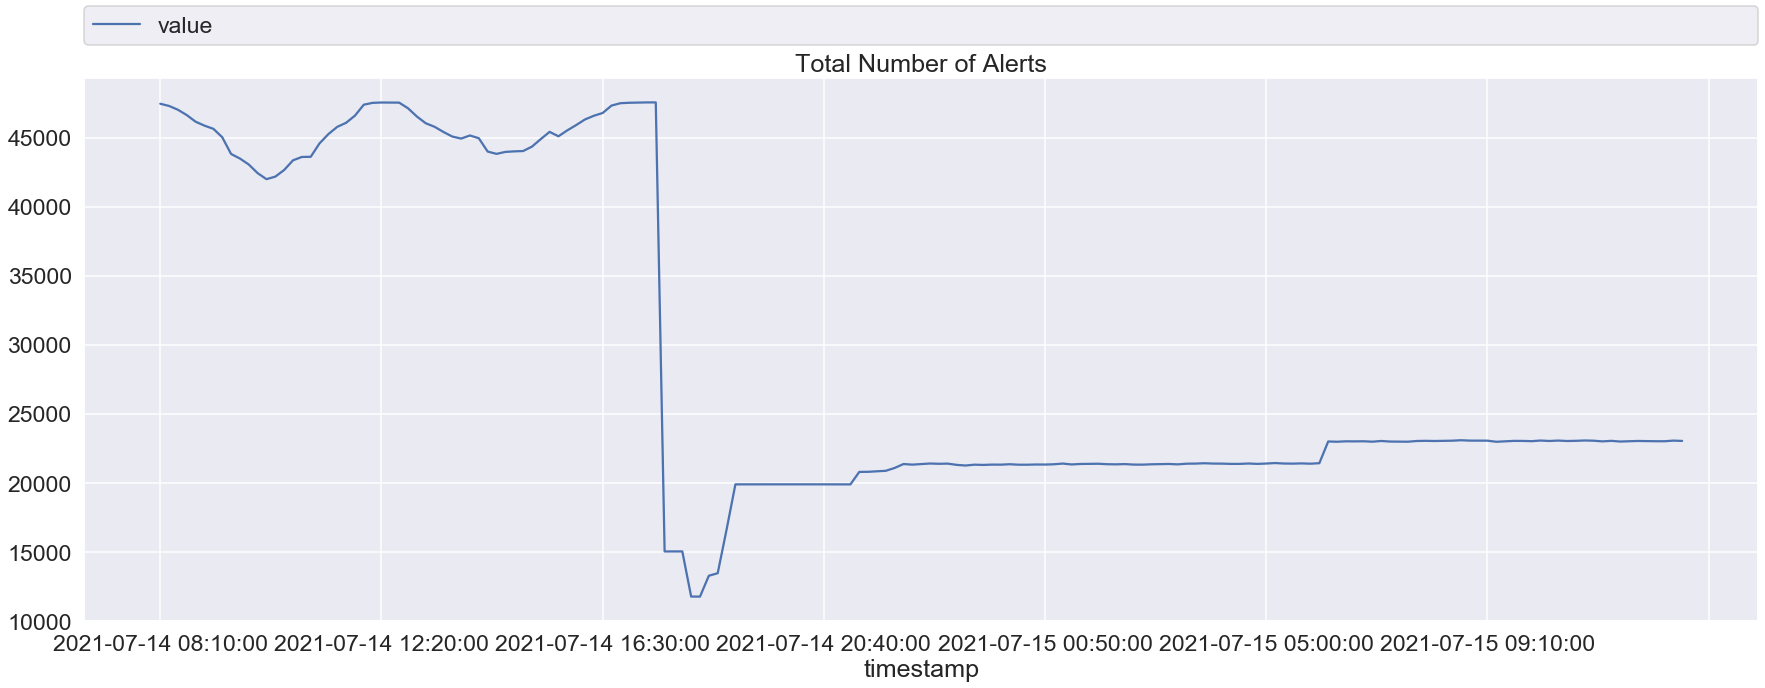

In [8]:
alert_count_df = alert_total_df.groupby(["timestamp"])["value"].sum()
print(alert_count_df.head())
ax=alert_count_df.plot(title="Total Number of Alerts")
ax.legend(bbox_to_anchor=(0., 1.06, 1., .102), loc='lower left', ncol=2, mode="expand", borderaxespad=0.)
plt.show()

### Number of Alerts by Cluster by time

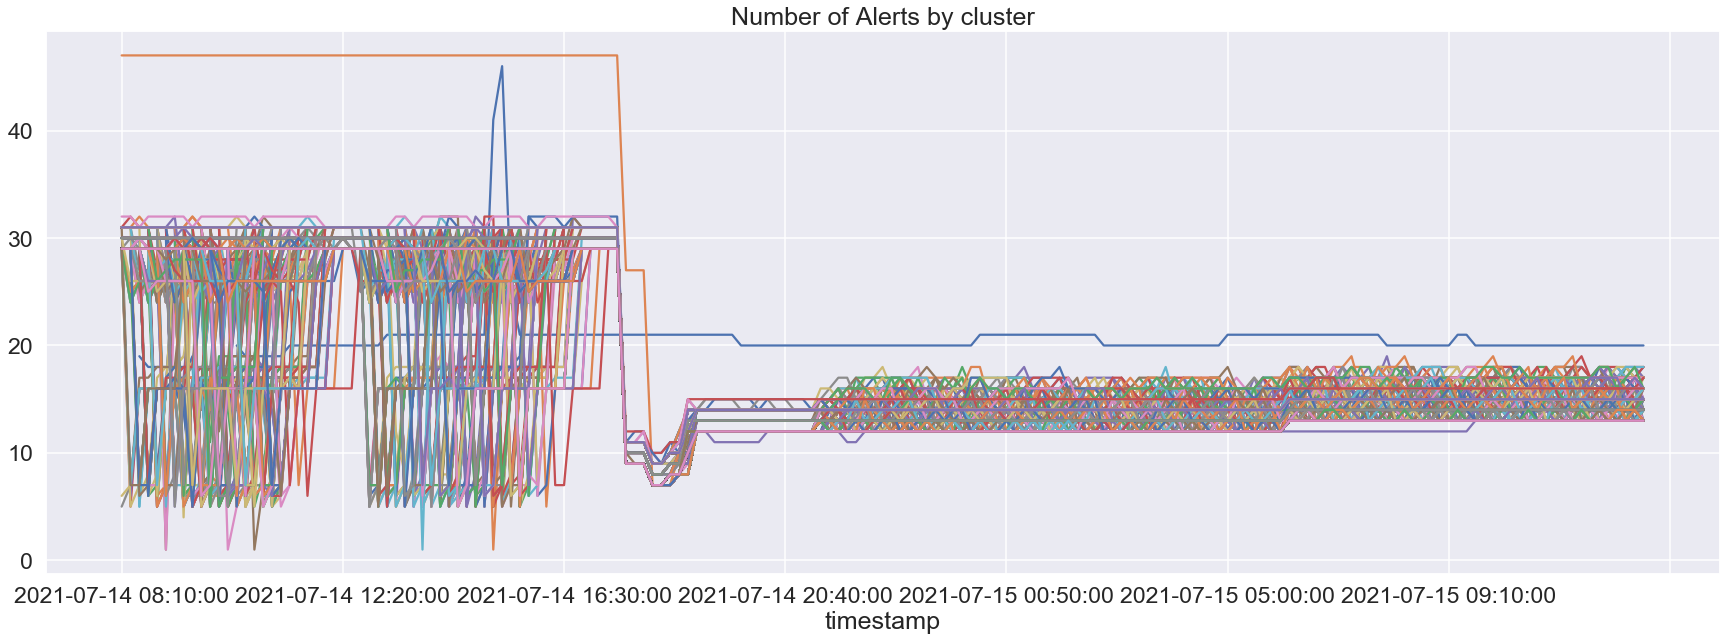

In [9]:

alert_cluster_df = alert_total_df.groupby(["cluster","timestamp"])["value"].sum()
alert_cluster_df=alert_cluster_df.unstack(level=0)
#print(alert_cluster_df.head())
ax=alert_cluster_df.plot(title="Number of Alerts by cluster")
ax.legend(bbox_to_anchor=(0., 1.06, 1., .102), loc='lower left', ncol=6, mode="expand", borderaxespad=0.)
#just removing the legend from being print
#its meaningless to show 1k labels
ax.get_legend().remove()
plt.show()

### Number of different Alerts by time

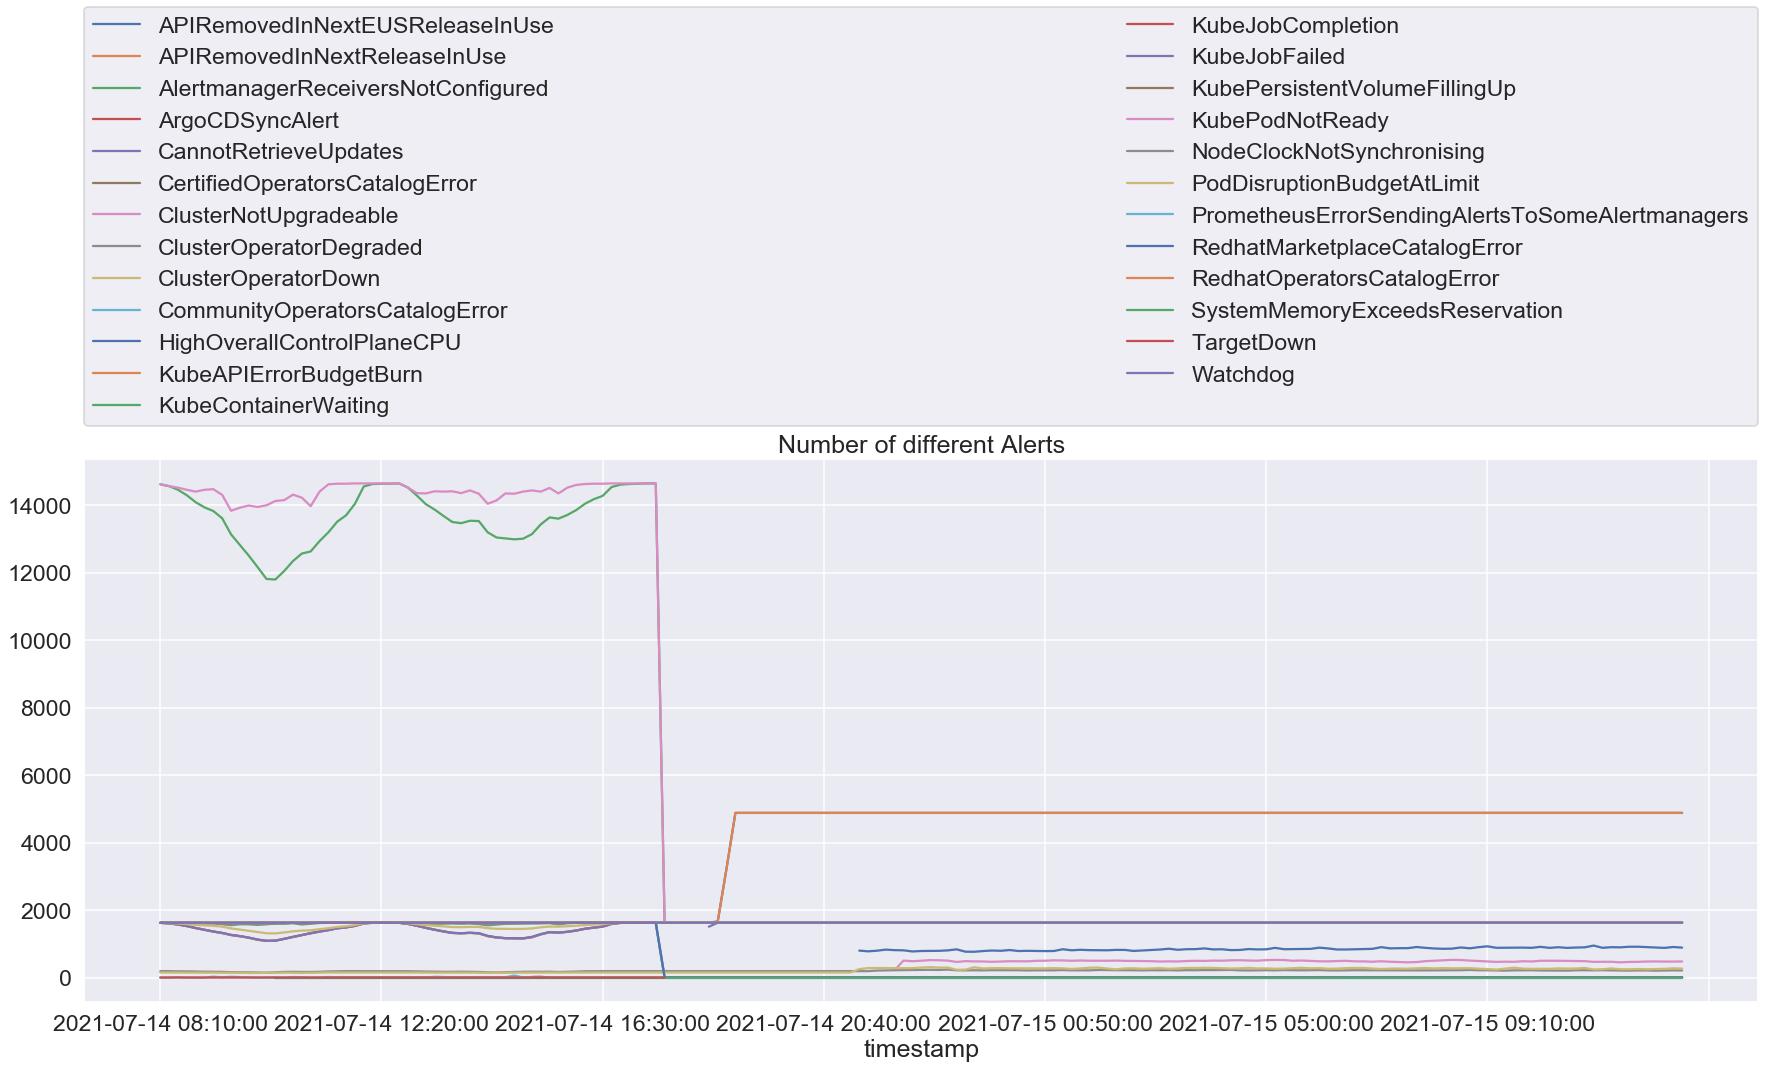

In [10]:
alert_alert_df = alert_total_df.groupby(["alertname","timestamp"])["value"].sum()
alert_alert_df=alert_alert_df.unstack(level=0)
#print(alert_alert_df.head())
ax=alert_alert_df.plot(title="Number of different Alerts")
ax.legend(bbox_to_anchor=(0., 1.06, 1., .102), loc='lower left', ncol=2, mode="expand", borderaxespad=0.)
plt.show()

### Highest Grossing Alerts

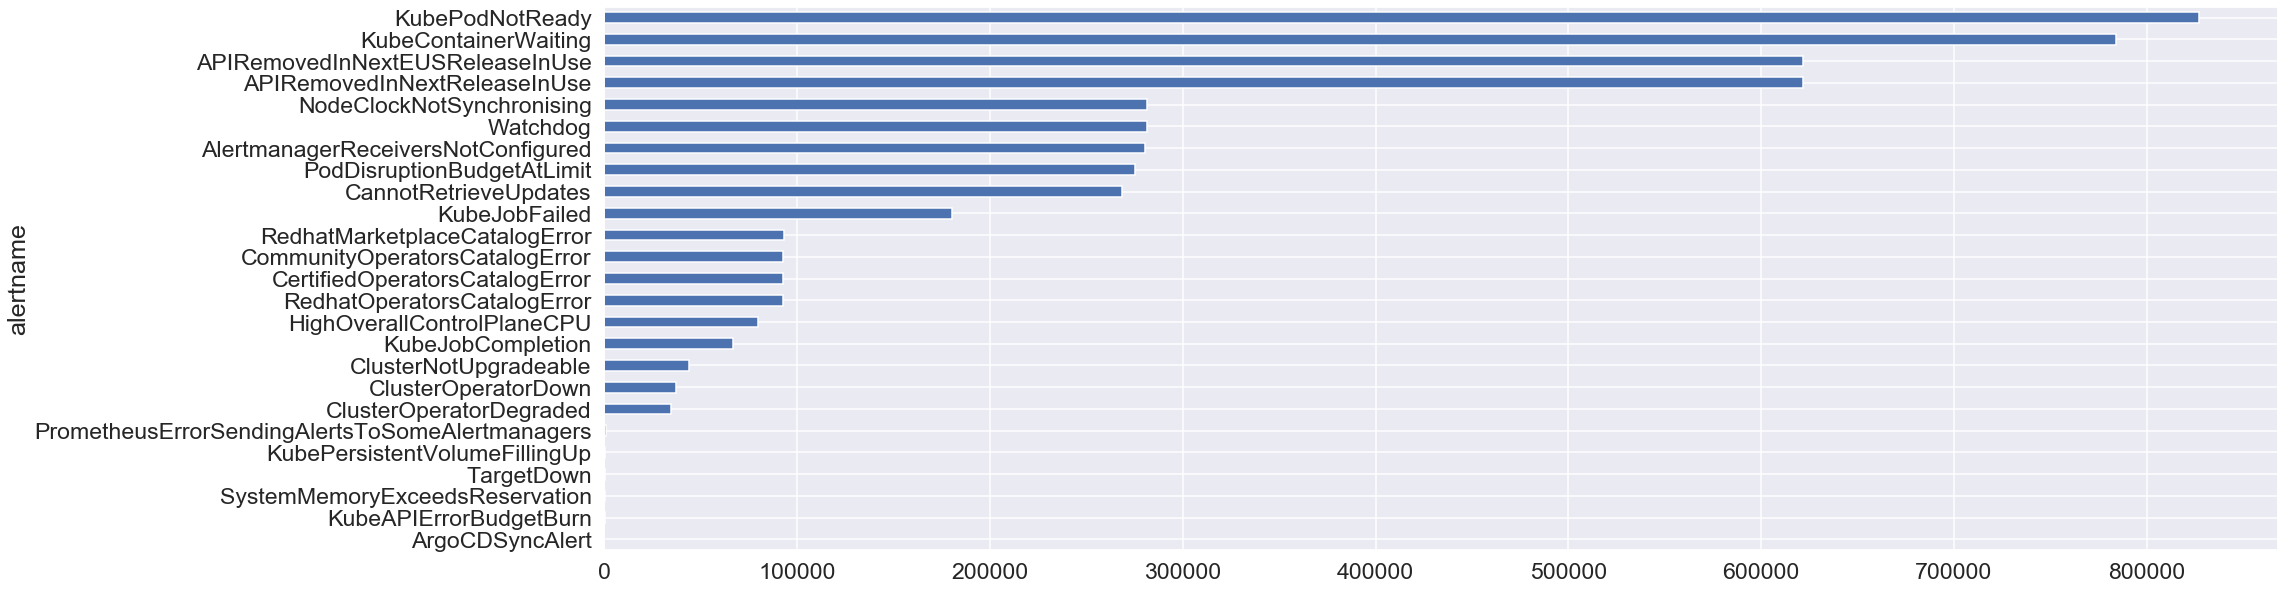

In [11]:
alert_slice_df = alert_total_df.groupby(["alertname"])["value"].sum()
#print(alert_slice_df.dtypes)
#plt.pie(alert_slice_df, labels = alert_slice_df["alertname"])
#plt.legend(title = "AlertName")
#plt.show()

ax = alert_slice_df.sort_values(ascending=True).plot.barh(x='alertname', y='value', rot=0)
#ax = alert_slice_df.plot.barh(x='alertname', y='value', rot=0)


#pandas.DataFrame.plot(data=alert_slice_df, y="value", kind='pie',  autopct='%.2f', labels=None,  ax=ax, title="ll", fontsize=10)
#ax.legend(loc=3, labels=alert_slice_df.index)

#ax = alert_slice_df.plot.pie(y="value",labels=None)
#ax.legend(labels, bbox_to_anchor=(0., 1.06, 1., .102), loc='lower left', ncol=1, mode="expand", borderaxespad=0.)


### Heatmap of clusters and Alerts

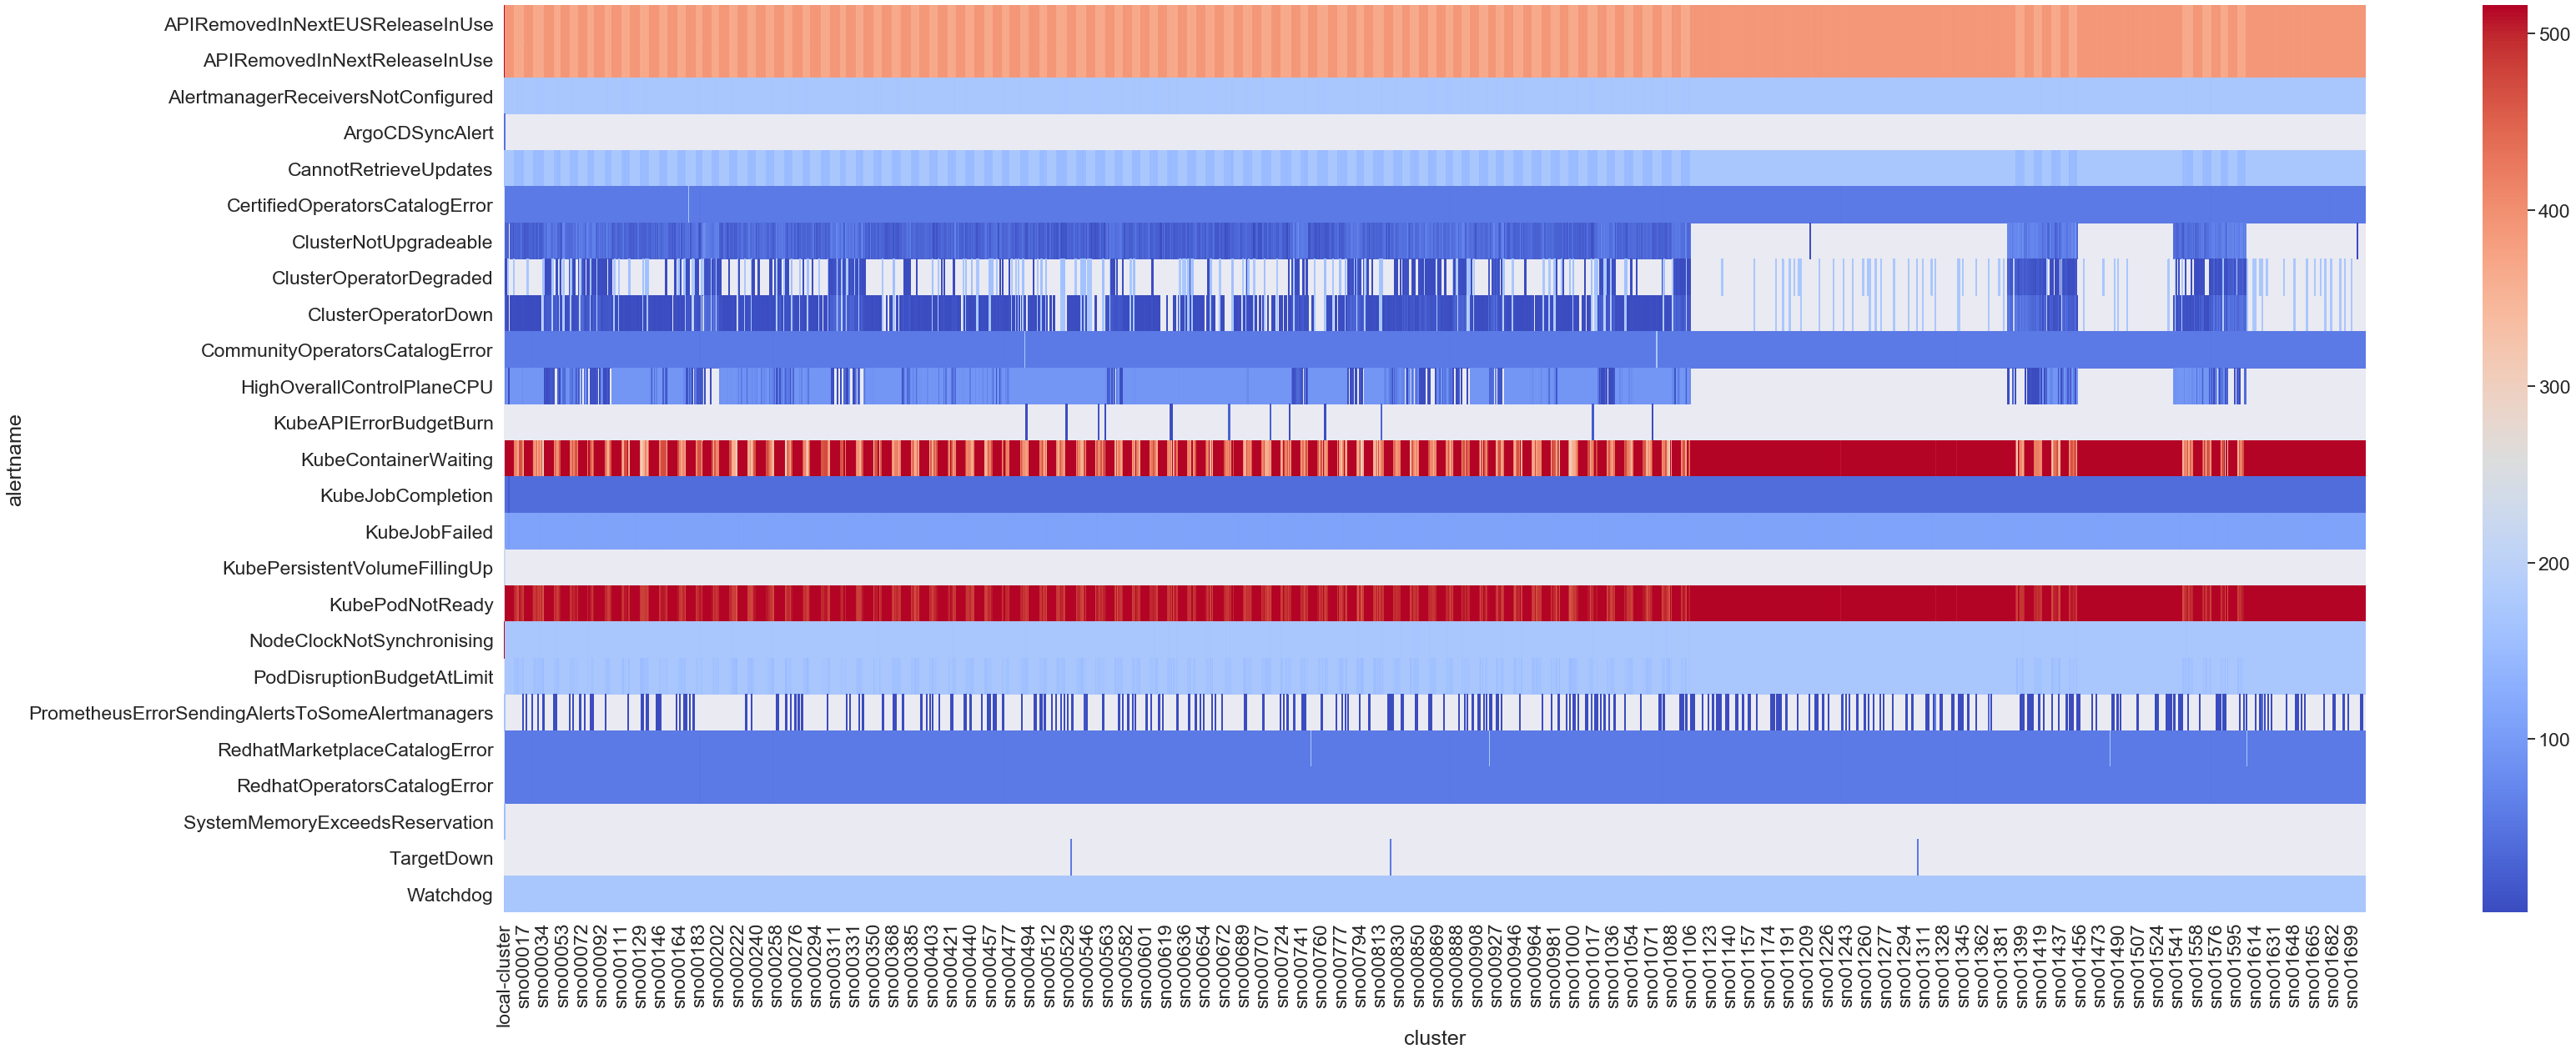

In [22]:
alert_cluster_scatter = alert_total_df.groupby(["cluster","alertname"])["value"].sum()
#print(alert_cluster_scatter.head())
#vmax = alert_cluster_scatter.values.min()
#vmin = alert_cluster_scatter.values.max()
#midpoint = (alert_cluster_scatter.values.min() - alert_cluster_scatter.values.max())/2

alert_cluster_scatter=alert_cluster_scatter.unstack(level=0)

fig, ax = plt.subplots(figsize=(50, 20))
#alert_cluster_scatter.set_xticks(np.arange(len(alert_total_df["cluster"])))

#alert_cluster_scatter.set_xticks(np.arange(len(alert_total_df["cluster"])))
#sns.heatmap(alert_cluster_scatter, cmap='coolwarm', center=midpoint)
# robust = True seems to be a good choice to remove noise. 
# sets contrast levels based on quantiles and works like an “auto-contrast” for choosing good values
ax=sns.heatmap(alert_cluster_scatter, cmap='coolwarm', robust=True)
#print(len(alert_total_df["cluster"].unique()))
ax.set_xticks=(len(alert_total_df["cluster"].unique()))
plt.show()

### Heatmap of clusters and Alerts with Alternate Visualization

In [31]:
#importing plotly and cufflinks in offline mode
import cufflinks as cf
import plotly.offline
cf.go_offline()
cf.set_config_file(offline=False, world_readable=True,dimensions=(6000,700))

alert_cluster_scatter = alert_total_df.groupby(["alertname","cluster"])["value"].sum()
alert_cluster_scatter=alert_cluster_scatter.unstack(level=0)

alert_cluster_scatter.iplot(kind='heatmap',colorscale="Oranges",
                            title="HeatMap of Alerts across Clusters", xTitle="Clusters")